# Notebook to calculate Statistics#

### Import the libraries###

In [120]:
import json
import zipfile
import os
import sys
import io
from ast import literal_eval
import pandas as pd
from itertools import chain
from itertools import groupby
import unicodedata
import numpy as np
import collections

from string import punctuation
translator = str.maketrans('','',punctuation) 

### Define all the necessary classes and functions###

In [121]:
class repository: 
    def __init__(self, policy, title, chapter, section, article):
        self.policy = policy
        self.title = title
        self.chapter = chapter
        self.section = section
        self.article = article
        
        
    def __repr__(self): #how to print the repository to the console
        return 'policy:' + self.policy + ' title:' + self.title + ' chapter:' + self.chapter + ' section:' + self.section + ' article:' + self.article          
   
    @classmethod
    def from_repository_name(cls, rep_str):                #2nd initializer that creates a repository object directly from a repository string e.g 'EU_32008R1099_Title_0_Chapter_0_Section_0_Article_03.txt'
        folder_parts = rep_str.split('_')                  #split the string at '_' into parts 
        policy = folder_parts[0] + '_' + folder_parts[1]   #we only want to split at every 2nd '_', so merge the 1. and 2., 3. and 4. again 
        if folder_parts[2] in  ['front', 'Whereas']:       #exeption for the 'whereas' and 'front'
            title = 'front'
            chapter = 'None'
            section = 'None'
            article = 'None'
        else:
            title = folder_parts[2] + '_' + folder_parts[3]
            chapter = folder_parts[4] + '_' + folder_parts[5]
            section = folder_parts[6] + '_' + folder_parts[7]
            article = folder_parts[8] + '_' + folder_parts[9]
        
        return cls(policy,title, chapter, section, article)  #return a repository with the previously defined attributes
    
    def match(self, other):            #checks if the search-criteria defined in repository 'other' is matching the the current repository                                                
        self_value_set = set([x for x in list(self.__dict__.values()) if x != 'None']) #creates a set of all the attributes ignoring 'None'    
        other_value_set = set([x for x in list(other.__dict__.values()) if x != 'None'])
        

        return set(other_value_set).issubset(self_value_set) #returns True if the attributes of the search-criteria is a subset of the attributes of the current directory (=match)
    
class token:
    def __init__(self, start, stop, text, rep, tag_count = 0):
        self.start = start
        self.stop = stop
        self.text = text
        self.rep = rep
        self.tag_count = tag_count
        
    def __repr__(self):
        return 'start:' + str(self.start) + ' stop:' + str(self.stop) + ' text:' + self.text + ' tag_count:' + str(self.tag_count)
        
    
class tag:
    def __init__(self, layer_, type_, tag_, start, stop, text, tokens, rep):
        self.layer_ = layer_
        self.type_ = type_
        self.tag_ = tag_
        self.start = start
        self.stop = stop
        self.text = text
        self.tokens = tokens
        self.rep = rep
        
        
    def __eq__(self, other): 
        if not isinstance(other, tag):
            # don't attempt to compare against unrelated types
            return NotImplemented

        return self.layer_ == other.layer_ and self.type_ == other.type_ and self.tag_ == other.tag_ and self.start == other.start and self.stop == other.stop
    
    def __repr__(self): #for debugging purpose, defines how object is printed
        return "layer:" + self.layer_ + " type:" + self.type_ + " tag:" + self.tag_ + " start:" + str(self.start) + " stop:" + str(self.stop) + " text:" + self.text + '\n'

    def get_start(self):
        return self.start
    
class Evaluator:
    
    def __init__(self, df):
        self.df = df
        
        
    def _get_iterator_all(self): #returns a iterator of all the tags present in the dataframe
        
        return chain.from_iterable(self.df['Tags'])
        
        
    def _get_iterator_conditional_rep(self, conditional_rep, column): #returns a list for all the tags that match the attributes defined in the 'conditional_rep' 
  
        iterator = chain.from_iterable(self.df[column])
        return [x for x in iterator if type(x)!= str and x.rep.match(conditional_rep) == True]
        
        
    def get_tag_list(self, conditional_rep, item, value):
       
        iterator = self._get_iterator_conditional_rep(conditional_rep, 'Tags')
        
        if item == 'None' and value == 'None':
            return [x for x in iterator if type(x)!= str ]
        if item == 'layer':
            return [x for x in iterator if type(x)!= str and x.layer_ == value]
        if item == 'type':
            return [x for x in iterator if type(x)!= str and x.type_ == value]
        if item == 'tag':
            return [x for x in iterator if type(x)!= str and x.tag_ == value]
        
    def get_tag_frequency(self, conditional_rep, item, value):
        return len(self.get_tag_list(conditional_rep, item, value))    

    def get_span_distro(self, conditional_rep, item, value, return_format, level = 'character'):
        
        tag_list = self.get_tag_list(conditional_rep, item, value)
        
        if level == 'character':
            len_list = [(x.stop - x.start) for x in tag_list]
        if level == 'token':
            len_list = [len(x.tokens) for x in tag_list]
            
        len_dict = collections.Counter(len_list)
        
        if return_format == 'dict':
            return dict(sorted(len_dict.items(), key=lambda item: item[1], reverse=True))
            
        
        if return_format == 'list':
            distro_list = []
            for i in range(1,max(len_list)+1):
                distro_list.append(len_list.count(i))
            return distro_list
                      
     
    def get_tag_count(self, conditional_rep, item, value):
        return len(self.get_tag_list(conditional_rep, item, value))
    
    def get_token_list_from_repository(self, conditional_rep):
        token_iterator = self._get_iterator_conditional_rep(conditional_rep, 'Tokens')
        return list(token_iterator)
    
    def get_token_count_from_repository(self, conditional_rep):
        return len(self.get_token_list_from_repository(conditional_rep))
        
       
    
    
    def get_tokens_from_tag_list(self, conditional_rep, item, value):
        tag_list = self.get_tag_list(conditional_rep, item, value)
        return list(chain.from_iterable([x.tokens for x in tag_list]))
    
    
    def get_token_count_from_tag_list(self, conditional_rep, item, value):
        return len(self.get_tokens_from_tag_list(conditional_rep, item, value)) 
    
    
    def most_frequent_labeled_tokens(self, conditional_rep, item, value):
        tag_list = self.get_tag_list(conditional_rep, item, value) #get the taglist of all the tag that match search criteria
        token_iterator = chain.from_iterable([x.tokens for x in tag_list]) #retrieve all the tokens from the tag list and create a iterator (since the list contains sublists)
        token_counter_dict = collections.Counter([x.text for x in token_iterator]) #get a list the text of the token, count the different elements and create a dict
        return dict(sorted(token_counter_dict.items(), key=lambda item: item[1], reverse=True))  #sort the dict by counts
    
    
    def get_label_count_per_token_distro(self, conditional_rep, return_format):
        token_iterator = self._get_iterator_conditional_rep(conditional_rep, 'Tokens')
        token_counter_dict = collections.Counter([x.tag_count for x in token_iterator]) #get a list the text of the token, count the different elements and create a dict
        label_counter_list = [x.tag_count for x in token_iterator]
        
        if return_format == 'dict':
            return dict(sorted(token_counter_dict.items(), key=lambda item: item[1], reverse=True))
        
        if return_format == 'list':
            distro_list = []
            for i in range(0,max(label_counter_list)+1):
                distro_list.append(label_counter_list.count(i))
            return distro_list
         
        
        
        
    
      
  
          
        

### Helper funtions###

In [122]:
def normalize_and_replace_text(sentence):
    doc = unicodedata.normalize("NFKD", sentence)
    doc = doc.replace('\r', '').replace('\n', ' ')

    
    return doc

def clean_text(doc):
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    no_numbers = [w if not w.isdigit() else '#' for w in words]

    return no_numbers

def get_repository_names(folder_name):
    folder_parts = folder_name.split('_')
    policy = folder_parts[0] + '_' + folder_parts[1]
    title = folder_parts[2] + '_' + folder_parts[3]
    chapter = folder_parts[4] + '_' + folder_parts[5]
    section = folder_parts[6] + '_' + folder_parts[7]
    article = folder_parts[8] + '_' + folder_parts[9]
    
    
     
    return policy, title, chapter, section, article



### Create the DataFrame ###

In [123]:
stat_df = pd.DataFrame(columns = ['Policy', 'Text','Tags', 'Tokens']) #create the initial dataframe
tagsets = ['Policydesigncharacteristics','Technologyandapplicationspecificity','Instrumenttypes']


In [124]:
path = '/home/kueddelmaier/Downloads/full_project_curated_json/curation'  #Datapath
subdirs = [o for o in os.listdir(path) if os.path.isdir(path)] #identify all the subdirs which correspond to different articles
os.chdir(path)

In [125]:
for subdir in subdirs:
   
    try:
        archive = zipfile.ZipFile(os.path.join(subdir, str(os.listdir(subdir)[0])), 'r') #decode compressed json in zip file
        json_file_byte = archive.read('CURATION_USER.json')      #this is a binary
        
        json_file_byte_decode = json_file_byte.decode('utf8')    #decode to json
    
        data = json.loads(json_file_byte_decode)
    
    except:
        stat_df = stat_df.append(pd.Series([subdir, 'error', 'error', 'error'], index=stat_df.columns ), ignore_index=True) #append error column if cannot read data

        
    else:
        taglist = []      #create epty list holding all the tags of the aragraph (= article)
        rep = repository.from_repository_name(subdir[0:-4])  #directory name in string format
        sentence = data['_referenced_fss']['1']['sofaString'].lower()  #raw text of the paragraph (all in lower case)
        all_tokens_json = data['_views']['_InitialView']['Token']
        all_tokens_json[0]['begin'] = 0                            #the first token is missing the beginning
        token_list = [token(x['begin'], x['end'], sentence[x['begin']:x['end']], rep) for x in all_tokens_json]
        sentence_normalized = normalize_and_replace_text(sentence) 
        
        for category in data['_views']['_InitialView']:  #loop trough the custom layers
  
            if category in tagsets:
                    
                for annotation in data['_views']['_InitialView'][category]: #loop trough all the tags
                    
                    type_ = list(annotation.keys())[-1]     #this part handles empty annotations. The last entry of the dict usually contains the type and the tag.
                                                            #for empty tags, the last entry is a integer
                    if type(type_) != str:                  
                        type_ = ''
                    
                    tag_ = list(annotation.values())[-1]
                    if type(tag_) != str:
                        tag_ = ''
                        
                    start = annotation['begin']
                    stop = annotation['end']
                    tag_tokens = [x for x in token_list if  x.start >= start and x.stop <= stop]
                    
                    for tag_token in tag_tokens:
                        tag_token.tag_count +=1
                    
                    taglist.append(tag(category, type_, tag_ , start ,stop , sentence[start:stop], tag_tokens, rep))
                    
        stat_df = stat_df.append(pd.Series([subdir[0:-4], sentence ,taglist, token_list], index=stat_df.columns ), ignore_index=True)     
stat_df['tokens cleaned'] = stat_df['Text'].apply(clean_text)  

## Small Tutorial



### Classes and Dataframe

All the information is now stored in a dataframe called "stat_df" containing the string of the directory path, the raw text, the tags  and the tokens(the cleaned tokens are not important for now):

In [126]:
stat_df.head()

,Policy,Text,Tags,Tokens,tokens cleaned
0,EU_32009L0028_Title_0_Chapter_0_Section_0_Arti...,article 7\r\njoint projects between member sta...,[layer:Policydesigncharacteristics type:Actor ...,"[start:0 stop:7 text:article tag_count:0, star...","[article, #, joint, projects, between, member,..."
1,EU_32019R0631_Title_0_Chapter_0_Section_0_Arti...,article 14\r\nadjustment of m0 and tm0 values\...,[layer:Instrumenttypes type:InstrumentType tag...,"[start:0 stop:7 text:article tag_count:0, star...","[article, #, adjustment, of, m0, and, tm0, val..."
2,EU_32019R0631_Title_0_Chapter_0_Section_0_Arti...,article 16\r\ncommittee procedure\r\n1. the ...,[layer:Policydesigncharacteristics type:Actor ...,"[start:0 stop:7 text:article tag_count:0, star...","[article, #, committee, procedure, #, the, com..."
3,EU_32008R1099_Title_0_Chapter_0_Section_0_Arti...,article 9\r\nrenewable energy statistics and f...,[layer:Instrumenttypes type:InstrumentType tag...,"[start:0 stop:7 text:article tag_count:0, star...","[article, #, renewable, energy, statistics, an..."
4,EU_32009L0028_Title_0_Chapter_0_Section_0_Arti...,article 12\r\ncapacity increases\r\nfor the pu...,[layer:Technologyandapplicationspecificity typ...,"[start:0 stop:7 text:article tag_count:0, star...","[article, #, capacity, increases, for, the, pu..."


The tags of each paragraph are stored in list:

In [127]:
stat_df['Tags'][2]

[layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:12 stop:21 text:committee,
 layer:Policydesigncharacteristics type:Actor tag:Authority_default start:42 stop:52 text:commission,
 layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:78 stop:102 text:climate change committee,
 layer:Policydesigncharacteristics type:Reference tag:Ref_OtherPolicy start:148 stop:173 text:regulation (eu) 2018/1999,
 layer:Policydesigncharacteristics type:Actor tag:Authority_legislative start:181 stop:200 text:european parliament,
 layer:Policydesigncharacteristics type:Actor tag:Authority_legislative start:212 stop:219 text:council,
 layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:231 stop:240 text:committee,
 layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:252 stop:261 text:committee,
 layer:Policydesigncharacteristics type:Reference tag:Ref_OtherPolicy start:284 stop:311 text:regulation (eu) no 182/2011,
 layer:P

Each tag has a class, type, tag, start, stop and the text (raw) 

In [128]:
stat_df['Tags'][2][2]

layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:78 stop:102 text:climate change committee

Further has each tag a repository and a list of all the tokens

In [129]:
stat_df['Tags'][2][2].rep

policy:EU_32019R0631 title:Title_0 chapter:Chapter_0 section:Section_0 article:Article_16

In [130]:
stat_df['Tags'][2][2].tokens

[start:78 stop:85 text:climate tag_count:1,
 start:86 stop:92 text:change tag_count:1,
 start:93 stop:102 text:committee tag_count:1]

It is important to note that the token objects reside in the separate column tokens, the list of tokens for each tag is just a pointer to those objects residing in the token column.

Each Token has a start, stop, text and a tag_count. The tag_count counts how many times this specific tokens has been labeled.

In [131]:
stat_df['Tokens'][2][2]

start:12 stop:21 text:committee tag_count:1

Repository's can be created trought the normal constructor **init**(self, policy, title, chapter, section, article) , or trough the classmethod **from_repository_name**(cls, rep_str), taking only a big string of the repository name. 

### Conditional Repository

The repository class can be used to create conditional repositorys, which are usefull to search in all the paragraphs matching a certain condition. Let's go on and create a test repository:

In [132]:
test_dir = repository.from_repository_name("EU_32008R1099_Title_0_Chapter_0_Section_0_Article_03")
test_dir

policy:EU_32008R1099 title:Title_0 chapter:Chapter_0 section:Section_0 article:Article_03

Let's now create a conditional repository. On each hirarchy, I can either match a certain name or I can match all the names by inserting 'None'. Simply speaking, we match all repositorys with the attributes given other than 'None. Let's assume I want to match all the tags in 'EU_32008R1099' I would create a repository like this:

In [133]:
test_dir = repository(policy = 'EU_32008R1099', title = 'None', chapter = 'None', section = 'None', article = 'None')

or simply

In [134]:
test_dir = repository('EU_32008R1099', 'None', 'None', 'None', 'None')

If I want to match all the tags that are stored in the first article in all the policy's, titles, chapters and sections

In [135]:
test_dir = repository('None', 'None', 'None', 'None', 'Article_01')

### Class Evaluator and evaluation functions

All the funtions calculating statistics are contained the class "evaluator", it's only class member is the dataframe:

In [136]:
test_evaluator = Evaluator(stat_df)

The most important funtion is the member function get_tag_list(self, conditional_rep, item, value). This functions takes a conditional repository (explained before), a item which can be either 'class, 'type' or 'tag' and a value. E.g item = 'layer' and value = 'Policydesigncharacteristics' or item = 'type and value ='Compliance' and item = 'tag' and value = 'Form_monitoring'. 

The function returns a list of all the tags in all the paragraphs matching the conditional repository and matching the item and value given. E.g I want to match all the tags of type 'Policydesigncharacteristics' in the policy 'EU_32008R1099':

In [137]:
test_dir = repository('EU_32008R1099', 'None', 'None', 'None', 'None')
test_evaluator.get_tag_list(item = 'layer', value = 'Policydesigncharacteristics', conditional_rep = test_dir)

[layer:Policydesigncharacteristics type:Compliance tag:Form_monitoring start:21 stop:38 text:energy statistics,
 layer:Policydesigncharacteristics type:Compliance tag:Form_monitoring start:43 stop:78 text:final energy consumption statistics,
 layer:Policydesigncharacteristics type:Objective tag:Objective_QualIntention_noCCM start:100 stop:181 text:improving the quality of renewable energy and final energy consumption statistics,
 layer:Policydesigncharacteristics type:Actor tag:Authority_monitoring start:187 stop:208 text:commission (eurostat),
 layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:187 stop:208 text:commission (eurostat),
 layer:Policydesigncharacteristics type:Actor tag:Authority_monitoring start:187 stop:197 text:commission,
 layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:187 stop:197 text:commission,
 layer:Policydesigncharacteristics type:Actor tag:Authority_monitoring start:199 stop:207 text:eurostat,
 layer:Policydesig

If I don't want to specify the item and the value, so match all the tags that match the conditional repository, I can put 'None':

In [138]:
test_evaluator.get_tag_list(item = 'None', value = 'None', conditional_rep = test_dir)

[layer:Instrumenttypes type:InstrumentType tag:RegulatoryInstr start:1343 stop:1363 text:regulatory procedure,
 layer:Instrumenttypes type:InstrumentType tag:RegulatoryInstr start:1525 stop:1545 text:regulatory procedure,
 layer:Policydesigncharacteristics type:Compliance tag:Form_monitoring start:21 stop:38 text:energy statistics,
 layer:Policydesigncharacteristics type:Compliance tag:Form_monitoring start:43 stop:78 text:final energy consumption statistics,
 layer:Policydesigncharacteristics type:Objective tag:Objective_QualIntention_noCCM start:100 stop:181 text:improving the quality of renewable energy and final energy consumption statistics,
 layer:Policydesigncharacteristics type:Actor tag:Authority_monitoring start:187 stop:208 text:commission (eurostat),
 layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:187 stop:208 text:commission (eurostat),
 layer:Policydesigncharacteristics type:Actor tag:Authority_monitoring start:187 stop:197 text:commission,
 laye

All the other member functions are based on the Evaluator.get_tag_list member function, they also take the same inputs. 

get_span_distro(self, conditional_rep, item, value, return_format) returns the distribution of spans of a tag_list either in dict{span:count} or list format. The lenght of the span can be calculated on character or token level:

In [139]:
test_evaluator.get_span_distro(item = 'None', value = 'None', conditional_rep = test_dir, return_format = 'dict', level = 'character')

{10: 33,
 19: 19,
 20: 16,
 8: 14,
 13: 14,
 17: 13,
 21: 12,
 6: 12,
 11: 11,
 9: 9,
 4: 8,
 18: 8,
 7: 7,
 35: 6,
 27: 6,
 15: 6,
 12: 6,
 16: 4,
 25: 4,
 5: 4,
 22: 3,
 31: 3,
 23: 2,
 14: 2,
 24: 2,
 29: 2,
 42: 2,
 28: 2,
 81: 1,
 3: 1,
 58: 1,
 34: 1,
 59: 1,
 99: 1,
 72: 1,
 76: 1,
 30: 1,
 108: 1,
 33: 1,
 45: 1,
 36: 1}

In [140]:
test_evaluator.get_span_distro(item = 'None', value = 'None', conditional_rep = test_dir, return_format = 'list')

[0,
 0,
 1,
 8,
 4,
 12,
 7,
 14,
 9,
 33,
 11,
 6,
 14,
 2,
 6,
 4,
 13,
 8,
 19,
 16,
 12,
 3,
 2,
 2,
 4,
 0,
 6,
 2,
 2,
 1,
 3,
 0,
 1,
 1,
 6,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

In [141]:
test_evaluator.get_span_distro(item = 'None', value = 'None', conditional_rep = test_dir, return_format = 'dict', level = 'token')

{1: 99,
 2: 85,
 4: 18,
 3: 16,
 5: 6,
 6: 5,
 9: 4,
 7: 3,
 11: 1,
 10: 1,
 8: 1,
 13: 1,
 14: 1,
 12: 1,
 15: 1}

This span ditro can also be plottet:

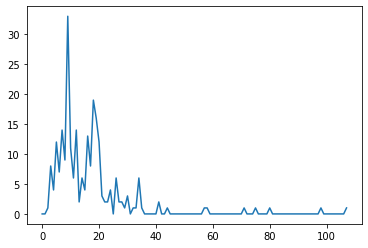

In [142]:
import matplotlib.pyplot as plt
plt.plot(test_evaluator.get_span_distro(item = 'None', value = 'None', conditional_rep = test_dir, return_format = 'list'))
plt.show()

get_tag_frequency(self, article, item, value) returns # of tags in the tag_list. Can be used to retrieve the amount of tags matching a certain condition. E.g all the tags of class 'Policydesigncharacteristics' in the policy 'EU_32008R1099':

In [143]:
test_evaluator.get_tag_frequency(item = 'layer', value = 'Policydesigncharacteristics', conditional_rep = test_dir)

203

get_tokens_from_tag_list(self, conditional_rep, item, value) returns a list of all the tokens in a taglist

In [144]:
test_evaluator.get_tokens_from_tag_list(item = 'layer', value = 'Policydesigncharacteristics', conditional_rep = test_dir)

[start:21 stop:27 text:energy tag_count:1,
 start:28 stop:38 text:statistics tag_count:1,
 start:43 stop:48 text:final tag_count:1,
 start:49 stop:55 text:energy tag_count:1,
 start:56 stop:67 text:consumption tag_count:1,
 start:68 stop:78 text:statistics tag_count:1,
 start:100 stop:109 text:improving tag_count:1,
 start:110 stop:113 text:the tag_count:1,
 start:114 stop:121 text:quality tag_count:1,
 start:122 stop:124 text:of tag_count:1,
 start:125 stop:134 text:renewable tag_count:1,
 start:135 stop:141 text:energy tag_count:1,
 start:142 stop:145 text:and tag_count:1,
 start:146 stop:151 text:final tag_count:1,
 start:152 stop:158 text:energy tag_count:1,
 start:159 stop:170 text:consumption tag_count:1,
 start:171 stop:181 text:statistics tag_count:1,
 start:187 stop:197 text:commission tag_count:4,
 start:198 stop:199 text:( tag_count:2,
 start:199 stop:207 text:eurostat tag_count:4,
 start:207 stop:208 text:) tag_count:2,
 start:187 stop:197 text:commission tag_count:4,
 star

get_token_count_from_tag_list returns the amount of tokens in the tag_list:

In [145]:
test_evaluator.get_token_count_from_tag_list(item = 'layer', value = 'Policydesigncharacteristics', conditional_rep = test_dir)

513

most_frequent_labeled_tokens(self, conditional_rep, item, value) returns a dict of all the most frequent tokens of a tag_list

In [146]:
test_evaluator.most_frequent_labeled_tokens(item = 'layer', value = 'Policydesigncharacteristics', conditional_rep = test_dir)

{'statistics': 54,
 'energy': 27,
 'commission': 24,
 'eurostat': 19,
 'the': 15,
 '/': 15,
 'national': 14,
 'of': 12,
 'and': 12,
 '(': 12,
 ')': 12,
 'member': 12,
 'states': 11,
 'ec': 9,
 'data': 8,
 'final': 7,
 'consumption': 7,
 'renewable': 6,
 'community': 6,
 'annual': 6,
 'nuclear': 6,
 'decision': 6,
 'european': 5,
 'regulation': 4,
 'no': 4,
 '\xa0': 4,
 'council': 4,
 'following': 4,
 'reported': 4,
 'statistical': 4,
 'monthly': 4,
 'studies': 3,
 '322': 3,
 '97': 3,
 'parliament': 3,
 'treaty': 3,
 '1999': 3,
 '468': 3,
 'months': 3,
 'year': 3,
 'for': 3,
 'monitoring': 3,
 'gas': 3,
 'producers': 3,
 'traders': 3,
 'distributors': 3,
 'transporters': 3,
 'importers': 3,
 'exporters': 3,
 'quality': 2,
 'pilot': 2,
 'cost-benefit': 2,
 'analyses': 2,
 'reporting': 2,
 '20th': 2,
 'day': 2,
 'its': 2,
 'publication': 2,
 'from': 2,
 '2009': 2,
 'period': 2,
 'committee': 2,
 'time': 2,
 '2005': 2,
 '166': 2,
 'mechanism': 2,
 'kyoto': 2,
 'protocol': 2,
 'users': 2,
 

get_label_count_per_token_distro(self, conditional_rep, return_format) returns a distribution of the tag_count for all the tokens in a conditional repository. This can be used to evaluate how many tokens have been labeled once, twice and so on. The distribution is returned in either list or dict.

In [147]:
test_evaluator.get_label_count_per_token_distro(conditional_rep = test_dir, return_format = 'dict')

{0: 1629, 1: 333, 2: 109, 3: 10, 4: 2}

In [148]:
test_evaluator.get_label_count_per_token_distro(conditional_rep = test_dir, return_format = 'list')

[1629, 333, 109, 10, 2]

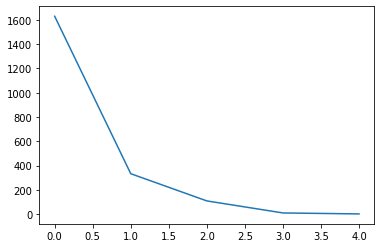

In [149]:
plt.plot(test_evaluator.get_label_count_per_token_distro(conditional_rep = test_dir, return_format = 'list'))
plt.show()

## A few important examples

Calculating all the # of paragraphs

In [150]:
len(stat_df)

89

total number of tags

In [151]:
total_corpus_dir = repository('None', 'None', 'None', 'None', 'None')
test_evaluator.get_tag_frequency(total_corpus_dir, 'None', 'None')

4004

To test that this is true,this should be equal to the # of tags in the dataframe.
First drop the error columns 

In [152]:
stat_df = stat_df.drop(stat_df[stat_df.Tags == 'error'].index)

In [153]:
len(list(chain.from_iterable(stat_df['Tags'])))

4004

Annotated tokens to total tokens

In [154]:
#Total:
test_evaluator.get_token_count_from_repository(total_corpus_dir)

41685

In [155]:
#annotated: (summing over all the tokens having a minimum one label)
sum(test_evaluator.get_label_count_per_token_distro(total_corpus_dir, 'list')[1:])

10039